In [ ]:
import kagglehub
mugheesahmad_sh17_dataset_for_ppe_detection_path = kagglehub.dataset_download('mugheesahmad/sh17-dataset-for-ppe-detection')
makhloufimohamed_safety_helmet_test_dataset_path = kagglehub.dataset_download('makhloufimohamed/safety-helmet-test-dataset')

print('Data source import complete.')


100%|██████████| 18.6M/18.6M [00:01<00:00, 10.2MB/s]

Extracting files...
Data source import complete.


In [ ]:
print("SH17 PPE dataset path:", mugheesahmad_sh17_dataset_for_ppe_detection_path)
print("Safety helmet test dataset path:", makhloufimohamed_safety_helmet_test_dataset_path)


SH17 PPE dataset path: /kaggle/input/sh17-dataset-for-ppe-detection
Safety helmet test dataset path: /root/.cache/kagglehub/datasets/makhloufimohamed/safety-helmet-test-dataset/versions/1


# PPE Detection Workflow

## 1. Exploratory Data Analysis (EDA)

### Import Libraries

In [ ]:
import os
import random
import json
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter
import pandas as pd
from glob import glob

### Load and Explore the Dataset

In [ ]:
import os

# Dataset path
BASE_PATH = "/root/.cache/kagglehub/datasets/makhloufimohamed/safety-helmet-test-dataset/versions/1"
print(os.listdir(BASE_PATH))


['test_dataset']


In [ ]:
# Paths
IMAGES_PATH = os.path.join(BASE_PATH, "images")
LABELS_PATH = os.path.join(BASE_PATH, "labels")
TRAIN_FILES = os.path.join(BASE_PATH, "train_files.txt")
VAL_FILES = os.path.join(BASE_PATH, "val_files.txt")

In [ ]:
def list_files_in_folder(folder_path, extension):
    """List all files with a specific extension in a folder."""
    return sorted(glob(os.path.join(folder_path, f"*.{extension}")))

def load_metadata(metadata_path):
    """Load metadata JSON file."""
    with open(metadata_path, 'r') as f:
        return json.load(f)

def load_label(label_path):
    """Load YOLO label file and parse it."""
    with open(label_path, 'r') as f:
        lines = f.readlines()
    return [line.strip().split() for line in lines]

### Analyze All Class Distribution

* 0: person
* 1: ear
* 2: ear-mufs
* 3: face
* 4: face-guard
* 5: face-mask
* 6: foot
* 7: tool
* 8: glasses
* 9: gloves
* 10: helmet
* 11: hands
* 12: head
* 13: medical-suit
* 14: shoes
* 15: safety-suit
* 16: safety-vest

In [ ]:

def analyze_class_distribution(labels_folder):
    """Analyze class distribution across all labels."""

    labels = list_files_in_folder(labels_folder, 'txt')

    class_instance_counter = Counter()
    class_image_counter = Counter()

    for label_file in labels:
        annotations = load_label(label_file)
        tmp_set = set()
        for annotation in annotations:
            class_id = annotation[0]
            class_instance_counter[class_id] += 1
            if class_id not in tmp_set :
                class_image_counter[class_id] += 1
                tmp_set.add(class_id)

    # Create first DataFrame with instance counts
    df = pd.DataFrame(class_instance_counter.items(), columns=['Class_ID', 'Count Instances'])
    df['Class_ID'] = df['Class_ID'].astype(int)
    df = df.sort_values('Class_ID')

    # Create second DataFrame with image counts
    df_img_count = pd.DataFrame(class_image_counter.items(), columns=['Class_ID', 'Count Images'])
    df_img_count['Class_ID'] = df_img_count['Class_ID'].astype(int)
    df_img_count = df_img_count.sort_values('Class_ID')

    # Merge the DataFrames on Class_ID
    combined_df = pd.merge(df, df_img_count, on='Class_ID', how='outer')

    # Sort by Class_ID and reset index
    combined_df = combined_df.sort_values('Class_ID').reset_index(drop=True)

    return combined_df

Count the number of instances for each class and the number of images containing each class.

In [ ]:

class_df = analyze_class_distribution(LABELS_PATH)
class_df.head()

,Class_ID,Count Instances,Count Images


In [ ]:
def plot_class_distribution(df, class_names, figsize=(12, 6)):
    """Plot class distribution with percentages and colors."""
    # Calculate percentages
    total = df['Count'].sum()
    df['Percentage'] = (df['Count'] / total * 100).round(1)

    # Sort the DataFrame by counts in descending order
    df = df.sort_values('Count', ascending=False)

    # Map class IDs to their names
    df['Class_Name'] = df['Class_ID'].map(lambda x: class_names[int(x)])

    # Create the plot
    plt.figure(figsize=figsize)
    colors = sns.color_palette("husl", len(df))
    barplot = sns.barplot(
        x='Class_Name',
        y='Count',
        data=df,
        palette=colors
    )

    # Add percentage labels above the bars
    for i, row in enumerate(df.itertuples()):
        barplot.text(
            i,
            row.Count + total * 0.003,
            f"{row.Percentage}%",
            ha='center',
            fontsize=10,
            color='black'
        )

    # Add labels and title
    plt.xlabel("Categories", fontsize=12)
    plt.ylabel("Instances", fontsize=12)
    plt.title("Class Distribution with Percentages", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

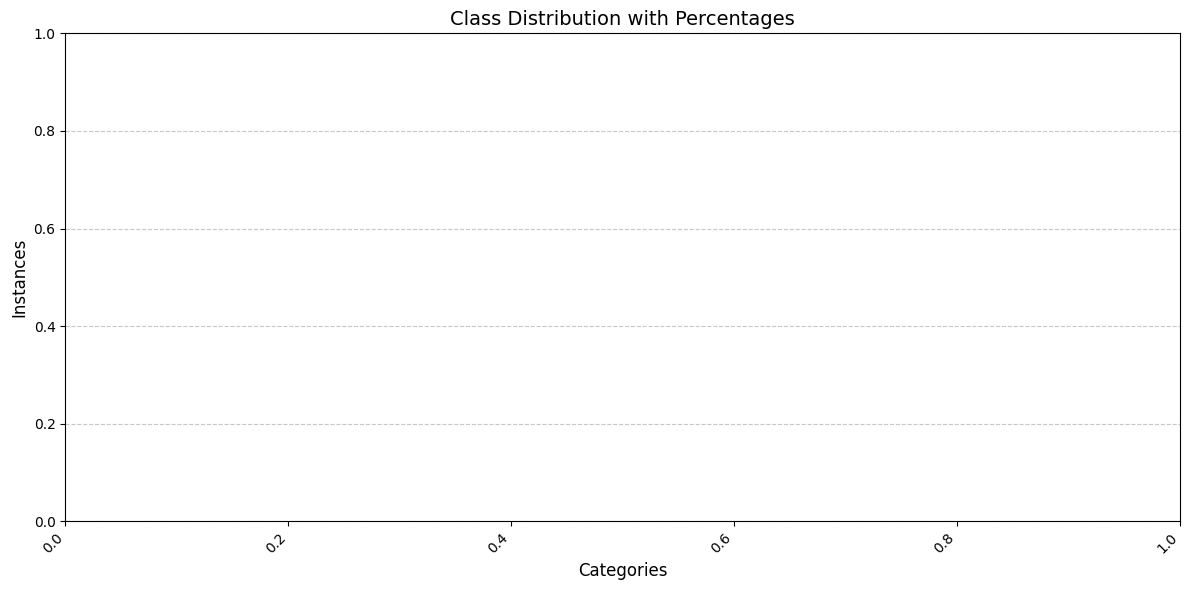

In [ ]:
class_names = [
    "Person", "Ear", "Ear-mufs", "Face", "Face-guard", "Face-mask",
    "Foot", "Tool", "Glasses", "Gloves", "Helmet", "Hands", "Head",
    "Medical-suit", "Shoes", "Safety-suit", "Safety-vest"
]
plot_class_distribution(class_df.rename(columns={'Count Instances': 'Count'}), class_names)

Visualize a sample of the data with annotations.

In [ ]:
def visualize_annotations(image_path, label_path, title=''):
    """Display an image with its bounding boxes."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    annotations = load_label(label_path)
    for annotation in annotations:
        class_id, x_center, y_center, width, height = map(float, annotation)
        h, w, _ = img.shape
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        cv2.putText(img, str(int(class_id)), (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [ ]:
sample_image = f'{IMAGES_PATH}/pexels-photo-9875413.jpeg'
sample_label = f'{LABELS_PATH}/pexels-photo-9875413.txt'
visualize_annotations(sample_image, sample_label)


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Zoom in on the class distribution to show only the person, helmet, and safety vest classes.

<ipython-input-9-5e9801569a14>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


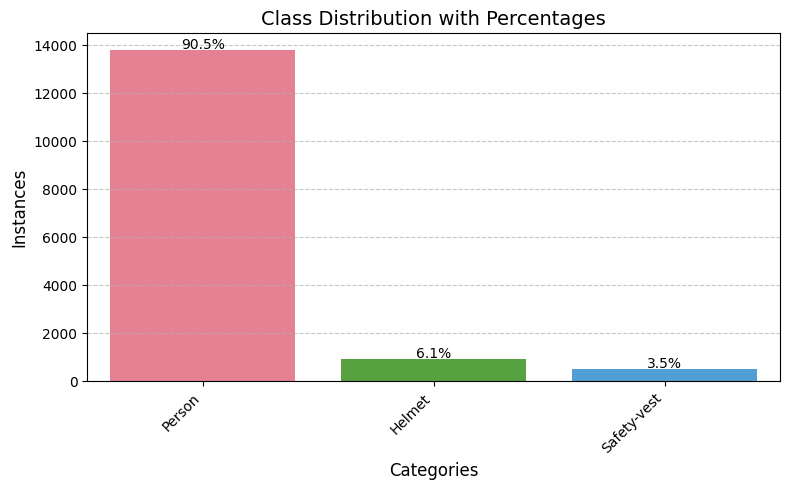

In [ ]:
filtered_df = class_df[class_df['Class_ID'].isin([0, 10, 16])].copy()
plot_class_distribution(filtered_df.rename(columns={'Count Instances': 'Count'}), class_names, figsize=(8, 5))

## 2. Dataset Filtering

In [ ]:
import os
import shutil

# Output directories for YOLO dataset structure
os.makedirs("/kaggle/working/dataset/images/train", exist_ok=True)
os.makedirs("/kaggle/working/dataset/images/val", exist_ok=True)
os.makedirs("/kaggle/working/dataset/labels/train", exist_ok=True)
os.makedirs("/kaggle/working/dataset/labels/val", exist_ok=True)

# Classes to retain: person (0), helmet (10), safety-vest (16)
TARGET_CLASSES = [0, 10, 16]

# Helper function to filter labels and move corresponding images
def filter_and_move(file_list, dest_images, dest_labels):
    with open(file_list, "r") as f:
        file_names = f.read().strip().split("\n")
    number_skip, number_move = 0, 0

    for file_name in file_names:
        base_name = os.path.splitext(file_name)[0]

        # Paths for source image and label
        img_src = os.path.join(IMAGES_PATH, file_name)
        label_src = os.path.join(LABELS_PATH, f"{base_name}.txt")

        # Skip if label does not exist
        if not os.path.exists(label_src):
            print(f"label does not exist {label_src}")
            continue

        # Read and filter label file
        filtered_lines = []
        with open(label_src, "r") as infile:
            for line in infile:
                class_id, *bbox = line.strip().split()
                if int(class_id) in TARGET_CLASSES:
                    # Map old class ID to new class ID (0, 1, 2)
                    new_class_id = TARGET_CLASSES.index(int(class_id))
                    filtered_lines.append(f"{new_class_id} {' '.join(bbox)}\n")  # Added \n here

        # Skip if no valid annotations remain
        if len(filtered_lines) == 0:
            number_skip += 1
            continue

        number_move += 1

        # Save filtered label
        label_dest = os.path.join(dest_labels, f"{base_name}.txt")
        with open(label_dest, "w") as outfile:
            outfile.writelines(filtered_lines)  # Now each line has proper line ending

        # Copy corresponding image
        shutil.copy2(img_src, os.path.join(dest_images, file_name))  # Fixed image copy path

    print(f"{number_skip} images skipped, and {number_move} were moved")

In [ ]:
# Process training and validation datasets
filter_and_move(TRAIN_FILES,
                "/kaggle/working/dataset/images/train",
                "/kaggle/working/dataset/labels/train")



365 images skipped, and 6114 were moved


In [ ]:
filter_and_move(VAL_FILES,
                "/kaggle/working/dataset/images/val",
                "/kaggle/working/dataset/labels/val")

100 images skipped, and 1520 were moved


In [ ]:
filtered_class_df = analyze_class_distribution('/kaggle/working/dataset/labels/train')
filtered_class_df.head()

,Class_ID,Count Instances,Count Images
0,0,11068,6102
1,1,773,373
2,2,433,168


In [ ]:
filtered_class_df_val = analyze_class_distribution('/kaggle/working/dataset/labels/val')
filtered_class_df_val.head()

,Class_ID,Count Instances,Count Images
0,0,2734,1515
1,1,154,93
2,2,97,45


<ipython-input-9-5e9801569a14>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


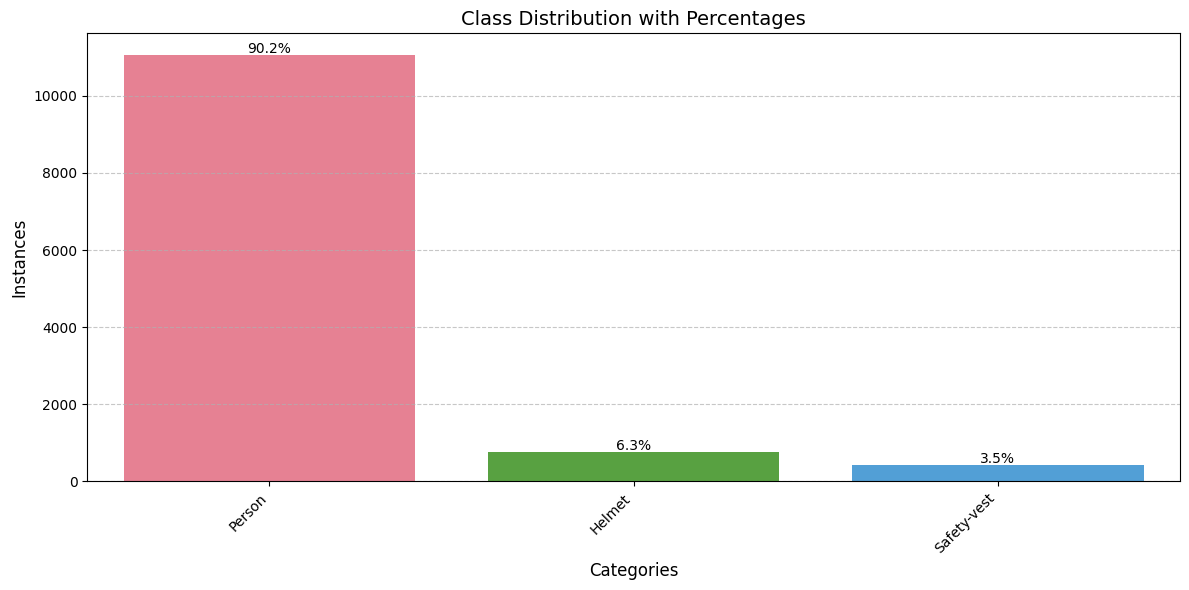

In [ ]:
safety_class_names = [
    "Person", "Helmet","Safety-vest"
]
plot_class_distribution(filtered_class_df.rename(columns={'Count Instances': 'Count'}), safety_class_names)

## 3. Imbalanced Data

In [ ]:
import os
import shutil

# Output directories for YOLO dataset structure
os.makedirs("/kaggle/working/undersampled_dataset/images/train", exist_ok=True)
os.makedirs("/kaggle/working/undersampled_dataset/images/val", exist_ok=True)
os.makedirs("/kaggle/working/undersampled_dataset/labels/train", exist_ok=True)
os.makedirs("/kaggle/working/undersampled_dataset/labels/val", exist_ok=True)

def undersampled_person_data( images_path, labels_path, dest_images, dest_labels, person_count):

    file_names = os.listdir(images_path)

    i= 0
    for file_name in file_names:

        base_name = os.path.splitext(file_name)[0]

        # Paths for source image and label
        img_src = os.path.join(images_path, file_name)
        label_src = os.path.join(labels_path, f"{base_name}.txt")

        # Skip if label does not exist
        if not os.path.exists(label_src):
            print(f"label does not exist {label_src}")
            continue

        filtered_lines = set()
        with open(label_src, "r") as infile:
            for line in infile:
                class_id, *bbox = line.strip().split()
                filtered_lines.add(int(class_id))

        filtered_lines = list(filtered_lines)

        if len(filtered_lines) == 1 and filtered_lines[0] == 0 and i>= person_count:
            continue
        if len(filtered_lines) == 1 and filtered_lines[0] == 0:
            i+=1

        label_dest = os.path.join(dest_labels, f"{base_name}.txt")
        shutil.copy2(label_src, label_dest)

        # Copy corresponding image
        shutil.copy2(img_src, dest_images)




In [ ]:
undersampled_person_data("/kaggle/working/dataset/images/train",
                "/kaggle/working/dataset/labels/train",
                "/kaggle/working/undersampled_dataset/images/train",
                "/kaggle/working/undersampled_dataset/labels/train", 90)

In [ ]:
undersampled_class_df = analyze_class_distribution('/kaggle/working/undersampled_dataset/labels/train')
undersampled_class_df.head()

,Class_ID,Count Instances,Count Images
0,0,1290,500
1,1,773,373
2,2,433,168


<ipython-input-9-5e9801569a14>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


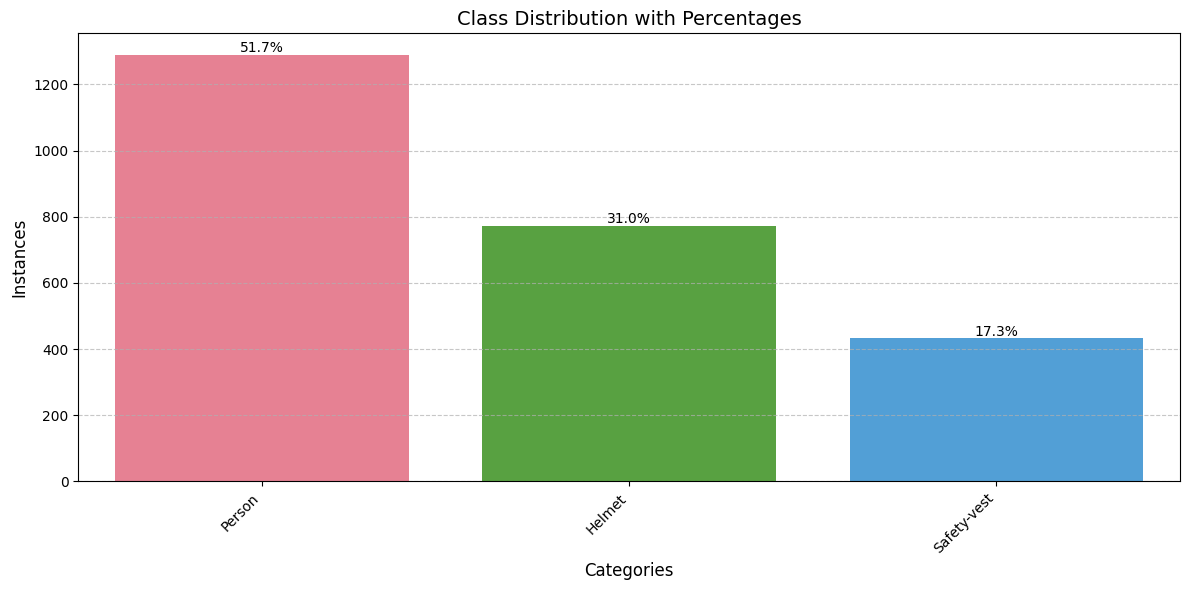

In [ ]:
plot_class_distribution(undersampled_class_df.rename(columns={'Count Instances': 'Count'}), safety_class_names)

In [ ]:
undersampled_person_data("/kaggle/working/dataset/images/val",
                "/kaggle/working/dataset/labels/val",
                "/kaggle/working/undersampled_dataset/images/val",
                "/kaggle/working/undersampled_dataset/labels/val", 30)

In [ ]:
undersampled_class_df_val = analyze_class_distribution('/kaggle/working/undersampled_dataset/labels/val')
undersampled_class_df_val.head()

,Class_ID,Count Instances,Count Images
0,0,310,131
1,1,154,93
2,2,97,45


## 4. Model Training

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
data_yaml = """
train: /kaggle/working/undersampled_dataset/images/train
val: /kaggle/working/undersampled_dataset/images/val
names:
  0: person
  1: helmet
  2: safety-vest
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(data_yaml)


In [ ]:
from ultralytics import YOLO
import torch
torch.cuda.empty_cache()
model = YOLO("yolov10m.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 32.1M/32.1M [00:00<00:00, 252MB/s]


In [ ]:
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


CUDA Available: True
Device Name: Tesla T4


In [ ]:
model.train(
    data="/kaggle/working/data.yaml",
    project="/kaggle/working/runs",
    batch=16,
    epochs=20,
    imgsz=640,
    # cache=True,
    optimizer = 'AdamW',
    lr0 = 1e-3
    # lrf = 0.01,
    # weight_decay = 5e-4,
    # dropout = 0.2,
    # patience = 100,
    # label_smoothing = 0.0
)

Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

100%|██████████| 755k/755k [00:00<00:00, 21.1MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1     78720  ultralytics.nn.modules.block.SCDown          [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1    228672  ultralytics

 16                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576, 192, 2]                 
 17                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192, 192, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  2    831744  ultralytics.nn.modules.block.C2fCIB          [576, 384, 2, True]           
 20                  -1  1    152448  ultralytics.nn.modules.block.SCDown          [384, 384, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  2   1911168  ultralytics.nn.modules.block.C2fCIB          [960, 576, 2, True]           
 23        [16, 19, 22]  1   2284450  ultralytics.nn.modules.head.v10Detect        [3, [192, 384, 576]]          
YOLOv10m summary: 288 layers, 16,487,602 parameters, 16,487,586 gradients, 64.0 GFLOPs



100%|██████████| 5.35M/5.35M [00:00<00:00, 59.0MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 130.9±47.7 MB/s, size: 880.4 KB)


train: Scanning /kaggle/working/undersampled_dataset/labels/train... 512 images, 0 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:01<00:00, 386.34it/s]

train: New cache created: /kaggle/working/undersampled_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 107.9±11.3 MB/s, size: 1895.4 KB)


val: Scanning /kaggle/working/undersampled_dataset/labels/val... 136 images, 0 backgrounds, 0 corrupt: 100%|██████████| 136/136 [00:00<00:00, 345.15it/s]

val: New cache created: /kaggle/working/undersampled_dataset/labels/val.cache


Plotting labels to /kaggle/working/runs/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/runs/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.49G      2.651      5.669      2.684        103        640: 100%|██████████| 32/32 [02:14<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:06<00:00,  1.37s/it]

                   all        136        561       0.36      0.292      0.276       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.49G      3.032      3.171      2.883        168        640: 100%|██████████| 32/32 [01:51<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        136        561      0.322      0.314      0.256      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.41G      3.119      3.174       2.96        144        640: 100%|██████████| 32/32 [01:52<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        136        561      0.214      0.206      0.138     0.0718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.57G      3.177      3.223      2.961        126        640: 100%|██████████| 32/32 [01:58<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]

                   all        136        561      0.376      0.328       0.29       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      8.55G      3.082      3.198      2.944         93        640: 100%|██████████| 32/32 [01:55<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]

                   all        136        561      0.397      0.257       0.24      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.36G      2.978      2.943      2.853        128        640: 100%|██████████| 32/32 [01:55<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.15it/s]

                   all        136        561      0.442      0.438      0.367      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.38G      2.944      2.801      2.807         98        640: 100%|██████████| 32/32 [01:54<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]

                   all        136        561      0.532      0.406      0.397      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.38G      2.911      2.765      2.775        205        640: 100%|██████████| 32/32 [01:54<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

                   all        136        561       0.59      0.492      0.502      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.35G      2.792      2.564      2.731        132        640: 100%|██████████| 32/32 [01:55<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

                   all        136        561      0.546      0.604      0.566      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.34G      2.743      2.584      2.688        146        640: 100%|██████████| 32/32 [01:49<00:00,  3.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        136        561      0.708      0.521      0.586      0.361


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.59G      2.658      2.569      2.667         66        640: 100%|██████████| 32/32 [02:06<00:00,  3.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        136        561      0.592      0.559       0.59       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.32G      2.636      2.404      2.642         81        640: 100%|██████████| 32/32 [01:53<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]

                   all        136        561      0.635      0.553      0.578      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       8.6G      2.503      2.209      2.545         40        640: 100%|██████████| 32/32 [01:53<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        136        561      0.619      0.607      0.633       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.34G      2.449      2.091      2.504         58        640: 100%|██████████| 32/32 [01:52<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.11it/s]

                   all        136        561      0.605      0.571      0.618      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.32G      2.366       1.93       2.48        114        640: 100%|██████████| 32/32 [01:55<00:00,  3.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

                   all        136        561      0.718      0.619      0.664      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.56G      2.359      1.878      2.466         78        640: 100%|██████████| 32/32 [01:53<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.08it/s]

                   all        136        561      0.669      0.667      0.673      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.35G      2.262      1.734      2.395         50        640: 100%|██████████| 32/32 [01:51<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.03s/it]

                   all        136        561      0.641      0.665      0.677      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.56G      2.181      1.672      2.364         85        640: 100%|██████████| 32/32 [01:53<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        136        561      0.738      0.604      0.687      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.32G      2.181      1.643      2.355         79        640: 100%|██████████| 32/32 [01:51<00:00,  3.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]

                   all        136        561      0.722      0.624      0.687      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.61G      2.104      1.565        2.3         49        640: 100%|██████████| 32/32 [01:51<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

                   all        136        561      0.752      0.646      0.701      0.464



20 epochs completed in 0.694 hours.
Optimizer stripped from /kaggle/working/runs/train/weights/last.pt, 33.5MB
Optimizer stripped from /kaggle/working/runs/train/weights/best.pt, 33.5MB

Validating /kaggle/working/runs/train/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 136 layers, 15,314,905 parameters, 0 gradients, 58.9 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<00:00,  5.52s/it]


                   all        136        561      0.751      0.646        0.7      0.465
                person        131        310      0.746      0.665      0.719      0.471
                helmet         93        154      0.811       0.75       0.79      0.568
           safety-vest         45         97      0.698      0.524      0.592      0.355
Speed: 0.2ms preprocess, 8.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /kaggle/working/runs/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x792ca86b3910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [ ]:
model = YOLO('/kaggle/working/runs/train/weights/best.pt')
model.export(format='onnx')


Ultralytics 8.3.146 🚀 Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLOv10m summary (fused): 136 layers, 15,314,905 parameters, 0 gradients, 58.9 GFLOPs

PyTorch: starting from '/kaggle/working/runs/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (31.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.53', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 7.8s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.53...
ONNX: export success ✅ 14.3s, saved as '/kaggle/working/runs/train/weights/best.onnx' (58.7 MB)

Export complete (16.3s)
Results saved to /kaggle/working/runs/train/weights
Predict:        

'/kaggle/working/runs/train/weights/best.onnx'

## 5. Evaluation

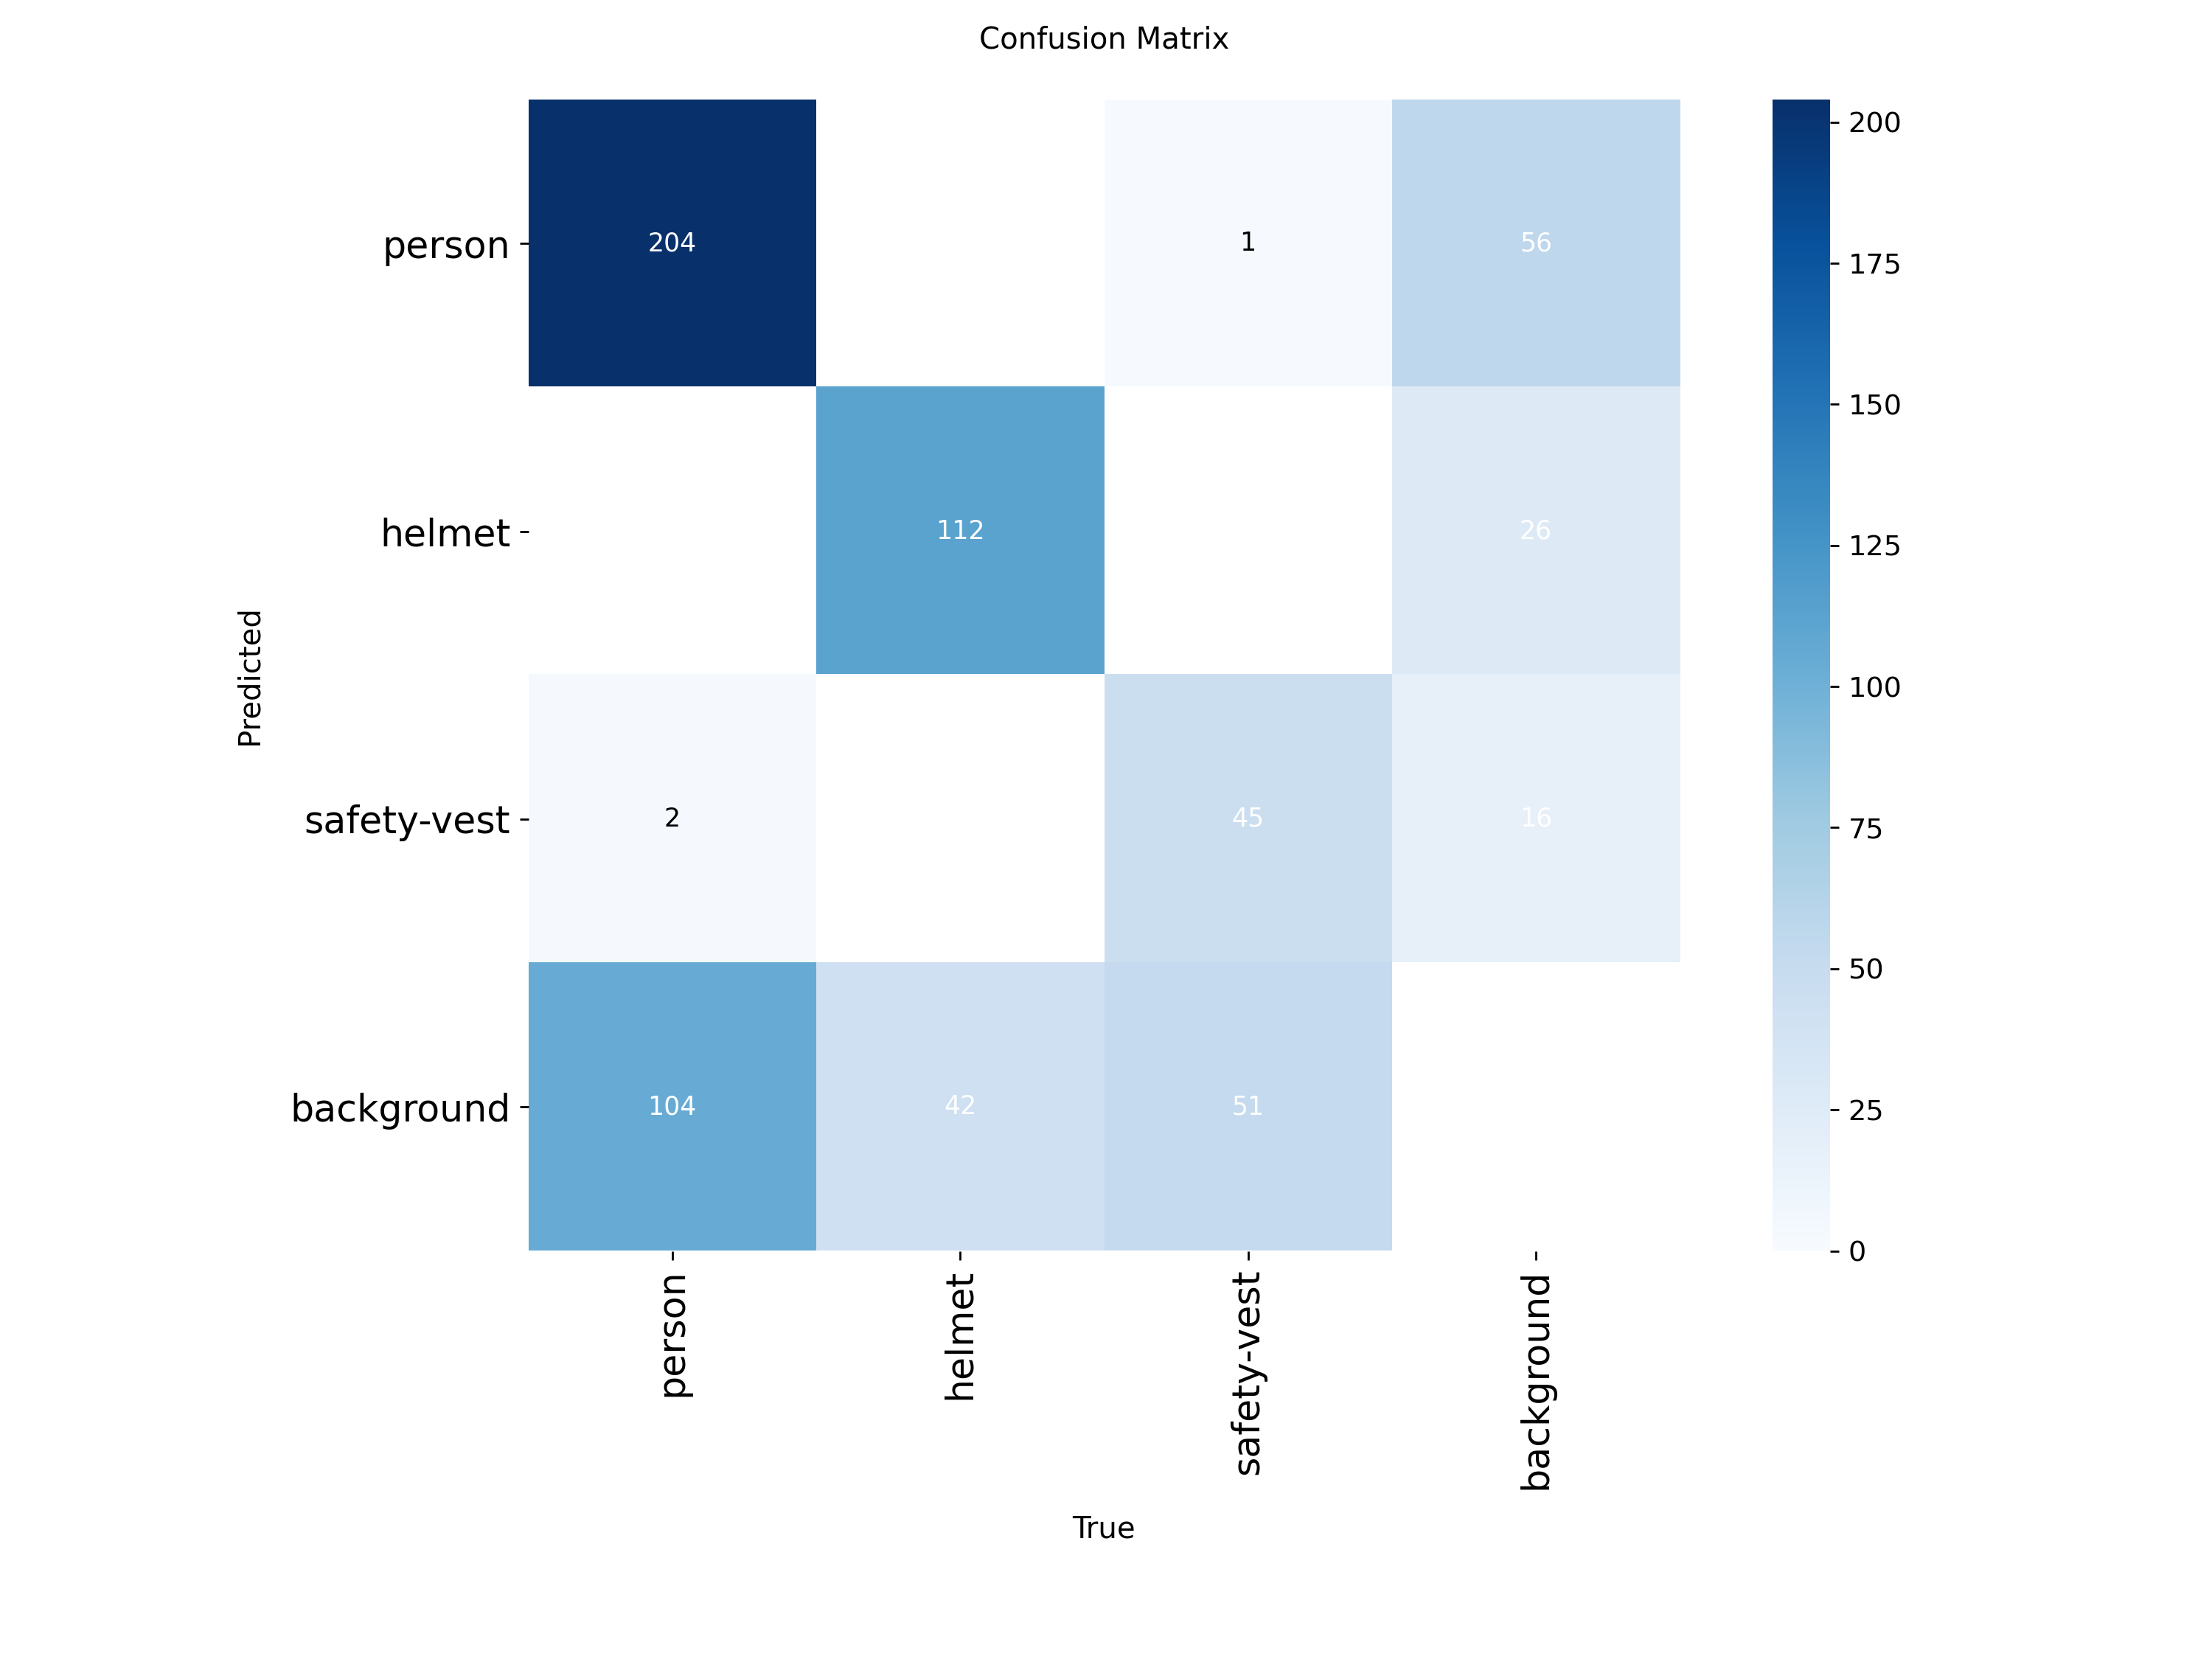

In [ ]:
from IPython.display import Image
Image(filename='/kaggle/working/runs/train/confusion_matrix.png', width=800)

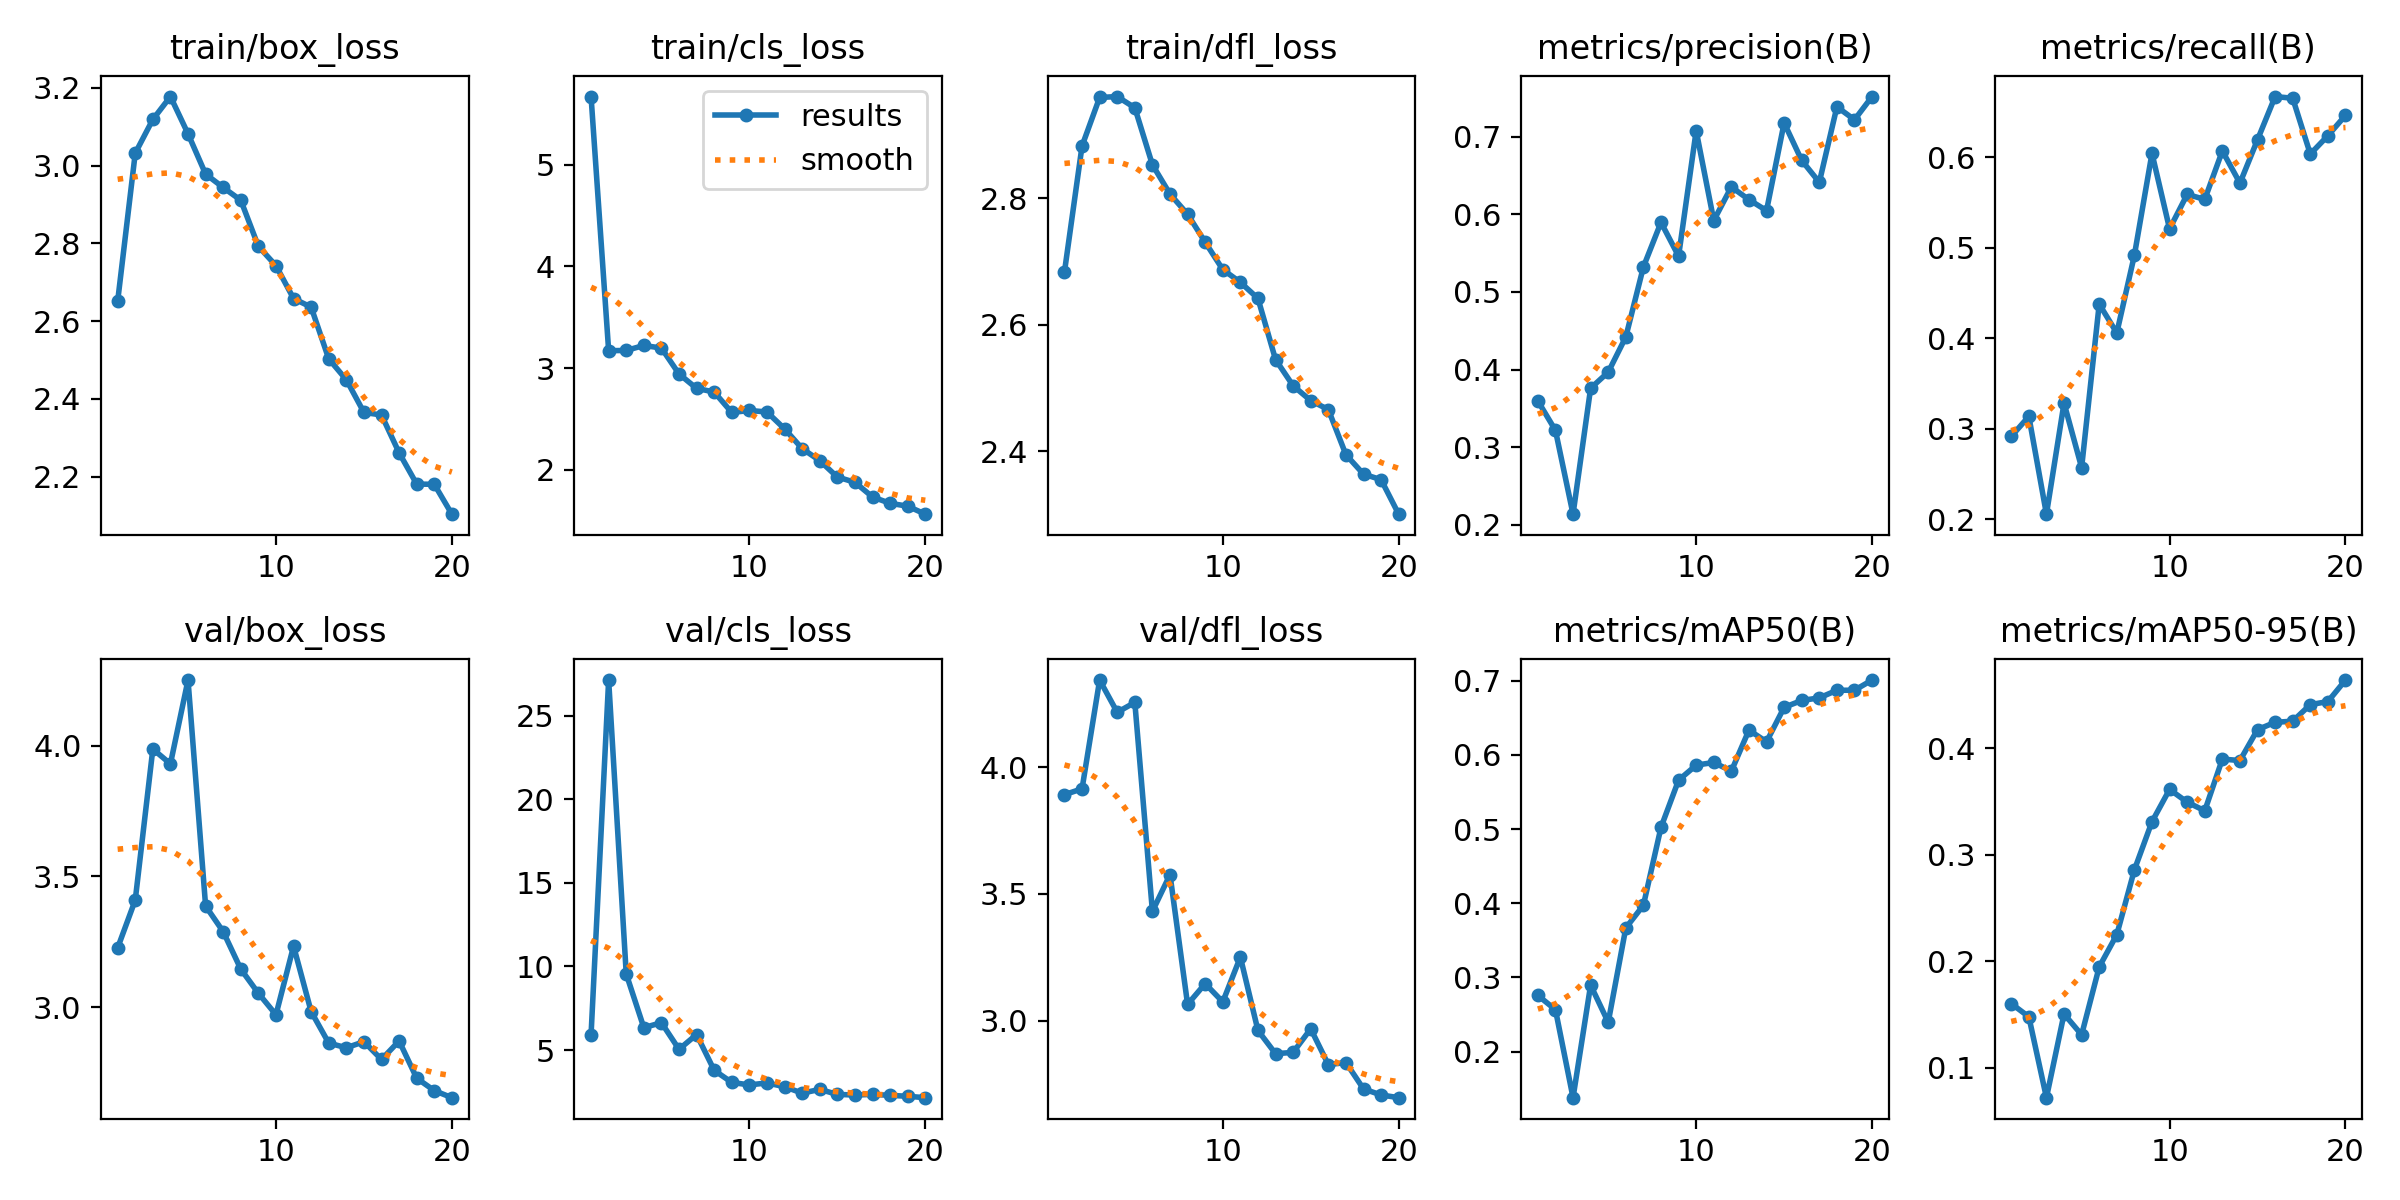

In [ ]:
Image(filename='/kaggle/working/runs/train/results.png', width=800)

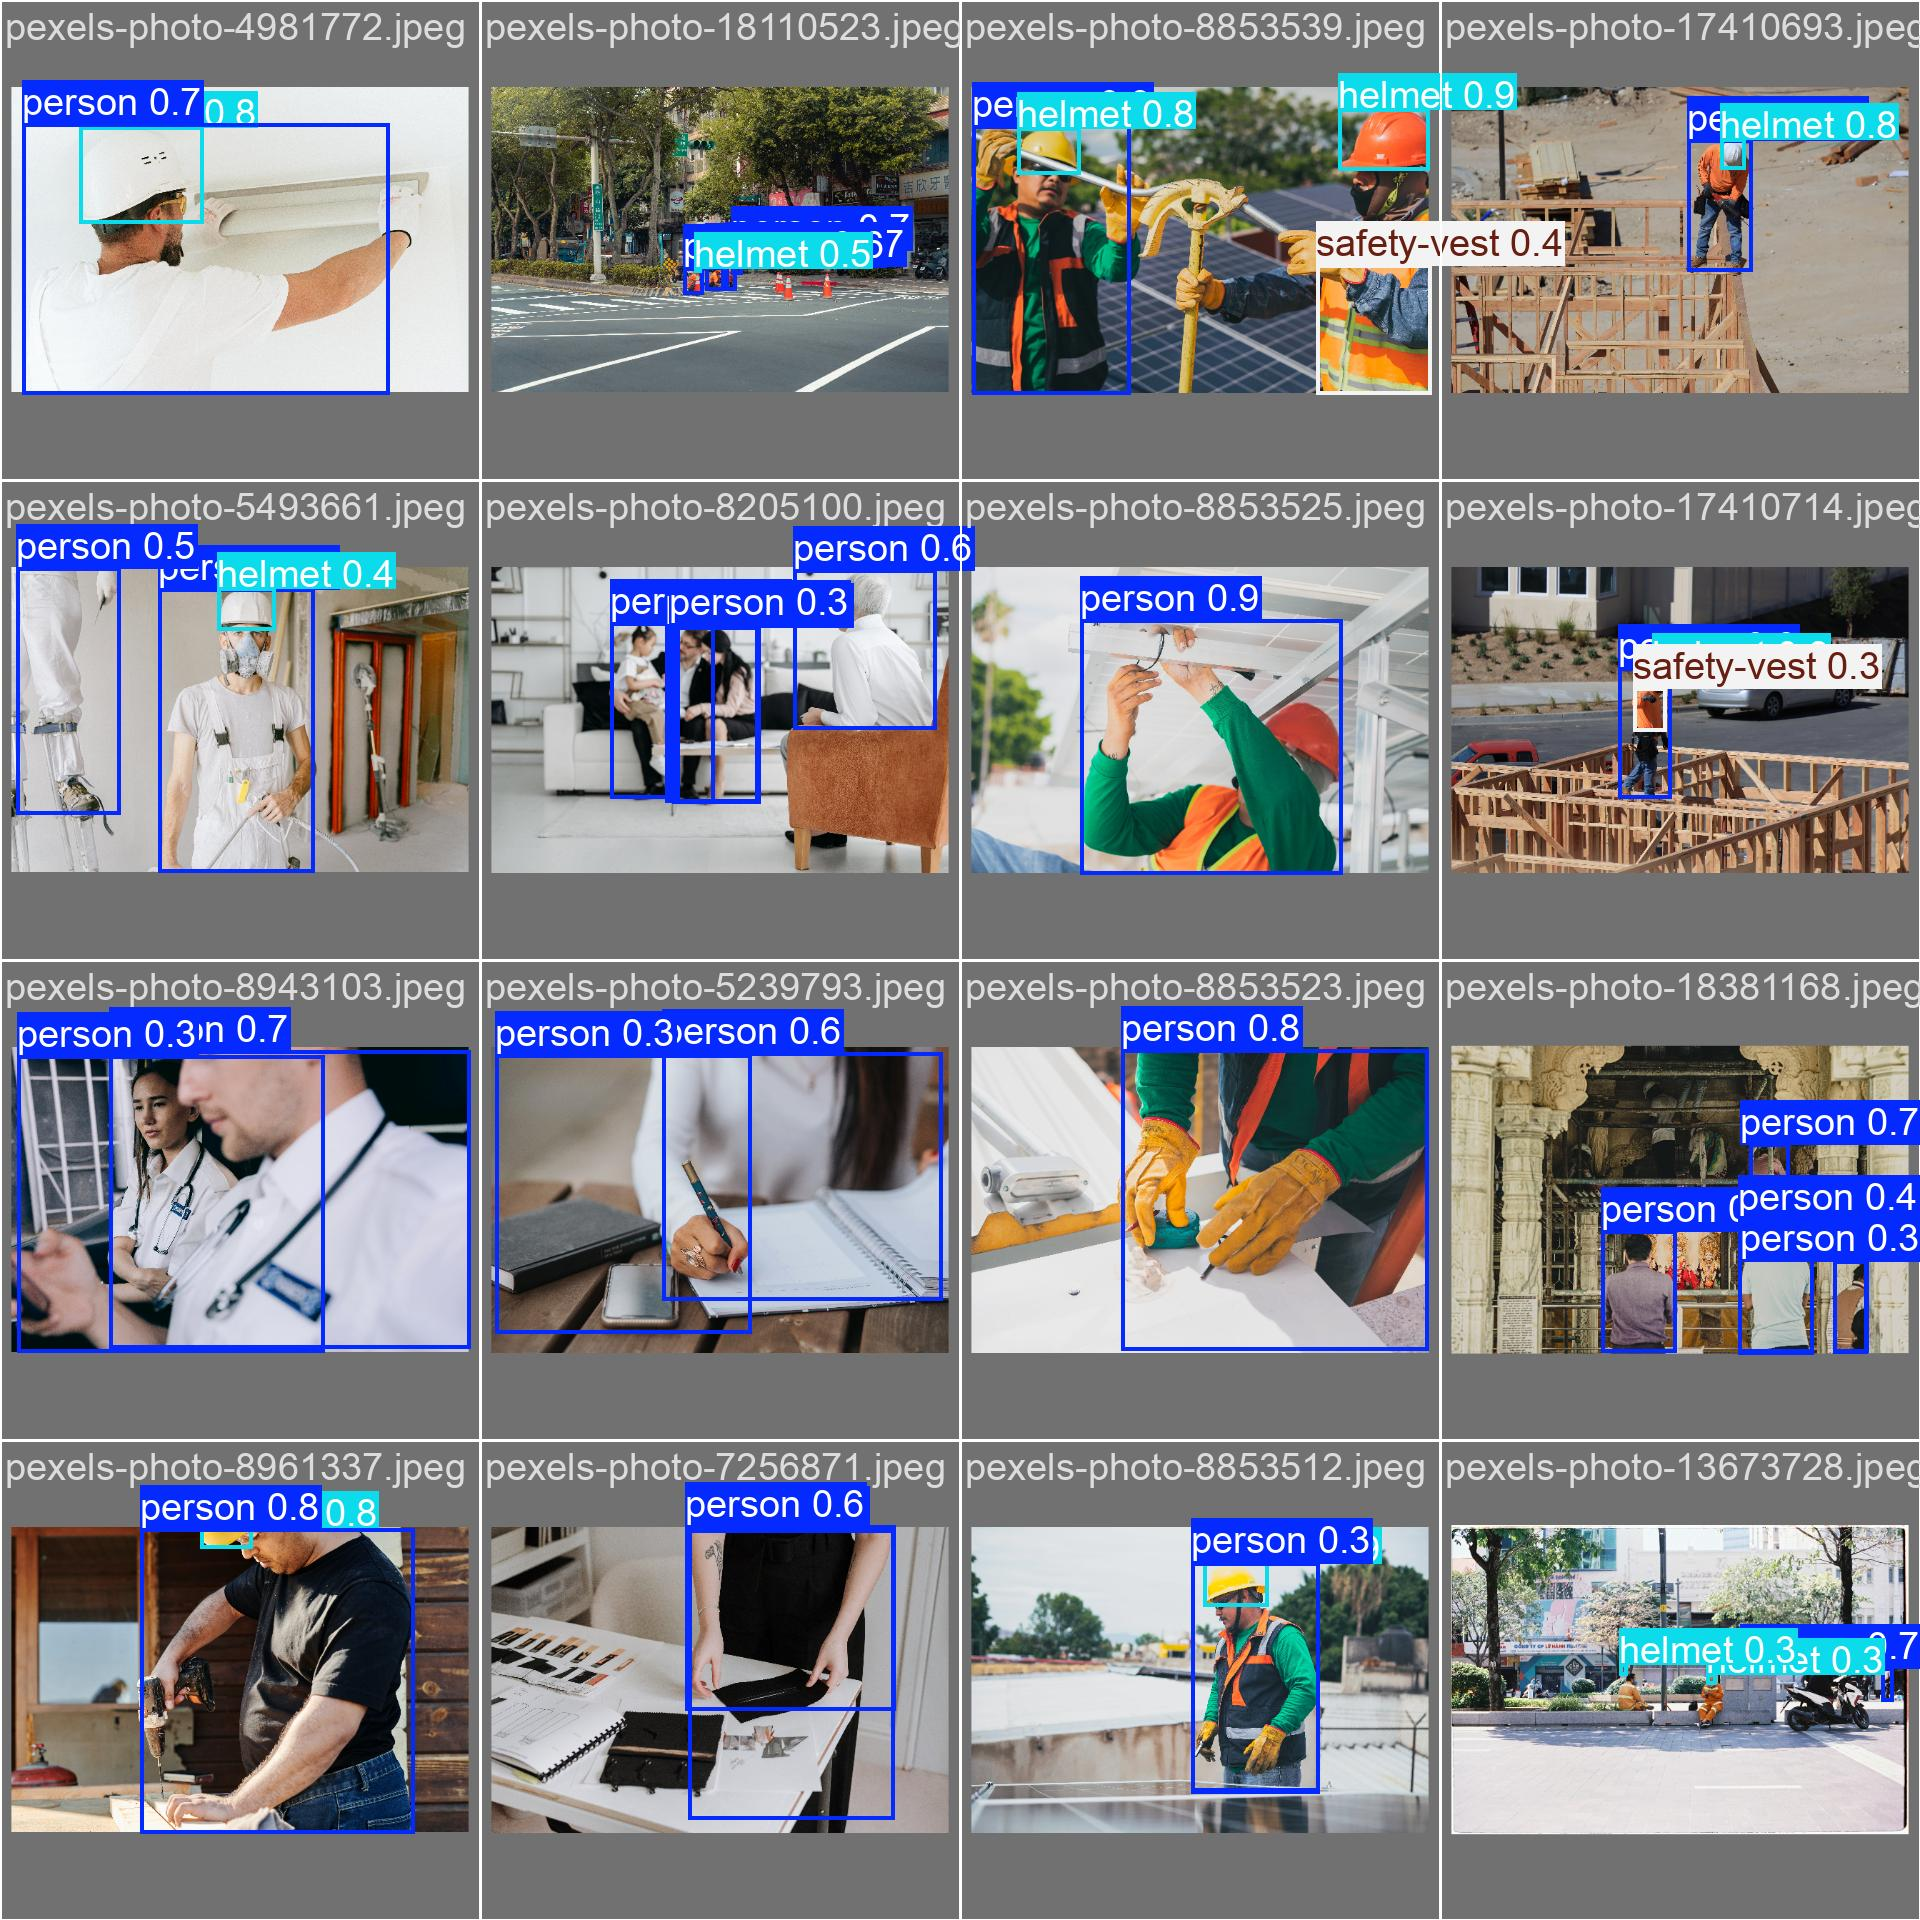

In [ ]:
Image(filename='/kaggle/working/runs/train/val_batch2_pred.jpg', width=800)

* Test the model with a real image:

* Display a sample test image.
* Show the detected bounding boxes.
* Display the labels corresponding to the detected objects.


image 1/1 /test_image.jpg: 448x640 7 persons, 8 helmets, 1 safety-vest, 57.9ms
Speed: 3.1ms preprocess, 57.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)
16 bounding boxes drawn.


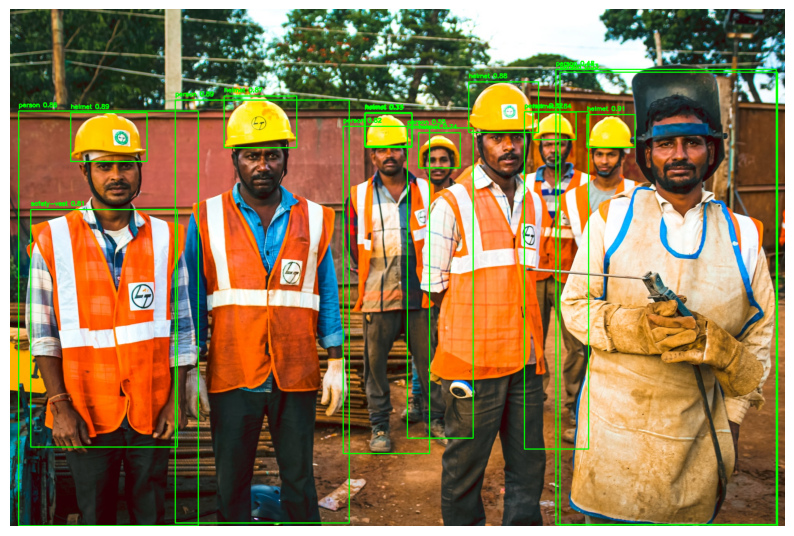

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# Path to the image
test_image_path = '/test_image.jpg'

# Perform inference
results = model.predict(source=test_image_path, conf=0.25)

# Check if results are available
if not results:
    print("No detection results found.")
    exit()

# Load the image
image = cv2.imread(test_image_path)

# Ensure the image is loaded
if image is None:
    raise ValueError("Failed to load the image. Check the file path.")

# Draw bounding boxes on the image
boxes_drawn = 0
for result in results:
    if not result.boxes:
        print("No bounding boxes detected.")
        continue

    for box, conf, cls in zip(result.boxes.xyxy, result.boxes.conf, result.boxes.cls):
        x1, y1, x2, y2 = map(int, box)  # Bounding box coordinates
        confidence = float(conf)  # Confidence score
        class_id = int(cls)  # Class ID
        label = f"{model.names[class_id]} {confidence:.2f}"

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        # Put the label on the image
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        boxes_drawn += 1

# Check if any boxes were drawn
if boxes_drawn == 0:
    print("No bounding boxes were drawn. Try lowering the confidence threshold or using a different image.")
else:
    print(f"{boxes_drawn} bounding boxes drawn.")

# Convert the image to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis("off")
plt.show()


## 6. Real-Time Detection

In [ ]:
#ktest_video_path = '/kaggle/input/safety-helmet-test-dataset/test_dataset/Safety Helmet Videos.mp4'

# Run the model on the video
#results = model.predict(source=test_video_path, conf=0.25, save=True)


Compress the predicted video size to make it easy to display.

In [ ]:
#!ffmpeg -i "/kaggle/working/runs/detect/predict/Safety Helmet Videos.mp4" -vf "scale=1280:720" -crf 28 -preset fast "/kaggle/working/runs/detect/predict/compressed_video.mp4"


In [ ]:
#from IPython.display import HTML
#from base64 import b64encode

#def play(filename):
    #html = ''
#    video = open(filename,'rb').read()
#    src = 'data:video/mp4;base64,' + b64encode(video).decode()
#    html += '<video width=1000 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
#    return HTML(html)

#play('/kaggle/working/runs/detect/predict/compressed_video.mp4')

